In [1]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import random
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
import os
import glob
import seaborn as sns
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
import pandas as pd
tqdm.pandas()
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import datetime

In [2]:
print(tf.__version__)

2.10.0


In [3]:
# Get the list of available devices
devices = tf.config.experimental.list_physical_devices()

# Print the list of available devices
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10143381685255369059
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1435539867
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2036119160999932839
 physical_device_desc: "device: 0, name: NVIDIA GeForce MX110, pci bus id: 0000:01:00.0, compute capability: 5.0"
 xla_global_id: 416903419]

In [6]:
tf.test.is_built_with_cuda()

True

In [7]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [8]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 224
    img_width = 224
    epochs = 100
    num_classes = 25
    img_channels = 3
    
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [9]:
# Labels
TRAIN_PATH = "./DatasetRGBS"
labels = os.listdir(TRAIN_PATH)
print(labels)


['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


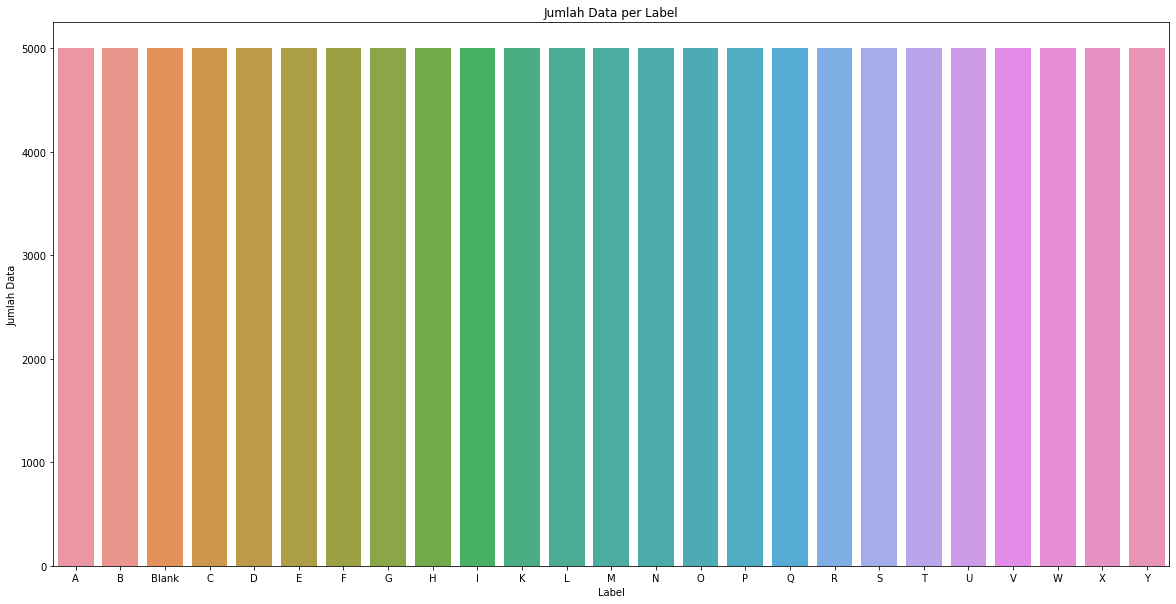

In [10]:
# plot jumlah data per label
def plot_label_dist():
    plt.figure(figsize=(20, 10))
    plt.title("Jumlah Data per Label")
    plt.xlabel("Label")
    plt.ylabel("Jumlah Data")
    sns.barplot(x=labels, y=[len(os.listdir(os.path.join(TRAIN_PATH, label))) for label in labels])
    plt.show()


plot_label_dist()

In [11]:
def sample_images(labels):
    # buat figure dengan ukuran 12x12
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in sibi Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

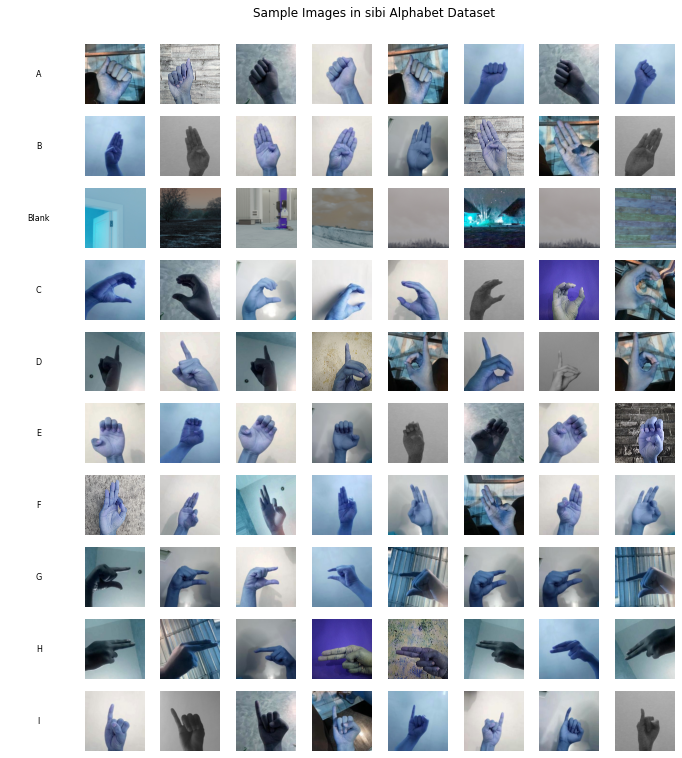

In [12]:
sample_images(labels[:10])

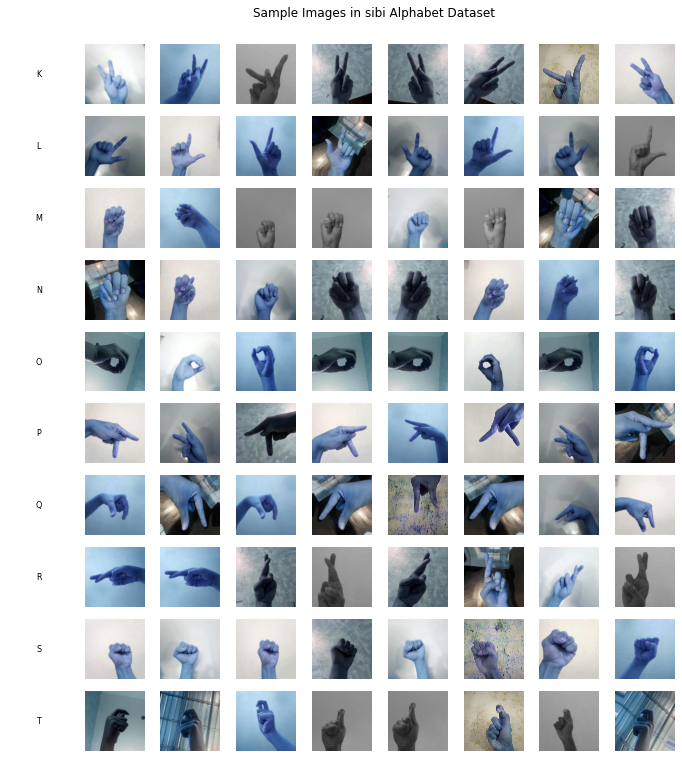

In [13]:
sample_images(labels[10:20])

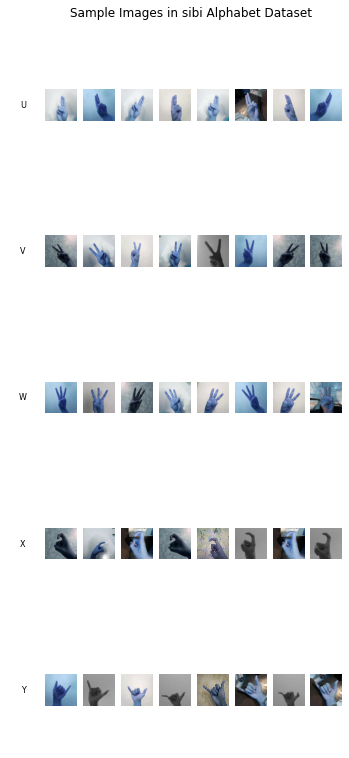

In [14]:
sample_images(labels[20:])

In [15]:
# create metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

image_path label
0       ./DatasetRGBS\A\000a50d8-53c8-47e2-871a-673aff...     A
1       ./DatasetRGBS\A\0010d657-ec42-43c3-a385-ed7003...     A
2       ./DatasetRGBS\A\003b3f0a-b706-4085-9fca-1adb1e...     A
3       ./DatasetRGBS\A\005576f8-6b07-40b9-a704-95f9df...     A
4       ./DatasetRGBS\A\007d5b44-abeb-40a5-93b5-62bc64...     A
...                                                   ...   ...
124995            ./DatasetRGBS\Y\IMG_20230614_070337.jpg     Y
124996            ./DatasetRGBS\Y\IMG_20230614_070338.jpg     Y
124997            ./DatasetRGBS\Y\IMG_20230614_070339.jpg     Y
124998          ./DatasetRGBS\Y\IMG_20230614_070339_1.jpg     Y
124999            ./DatasetRGBS\Y\IMG_20230614_070340.jpg     Y

[125000 rows x 2 columns]

In [16]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"], 
    test_size=0.15, 
    random_state=2023, 
    shuffle=True, 
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

print("Train Data")
display(data_train)
print("Val Data")
display(data_val)
print("Test Data")
display(data_test)

Train Data


image_path label
102198  ./DatasetRGBS\U\8d8351e8-c3df-4068-8dbf-678c39...     U
77911   ./DatasetRGBS\P\bc55eebe-cb8d-45e8-af44-631e65...     P
97883   ./DatasetRGBS\T\bd7512bd-b326-48c7-8d44-2930a6...     T
96517   ./DatasetRGBS\T\62663546-28fe-42ca-aba9-f03984...     T
52506   ./DatasetRGBS\K\9c1fa0e6-64a9-4d20-97fb-111bf7...     K
...                                                   ...   ...
23880   ./DatasetRGBS\D\f847b71c-73ac-4d4b-b14e-27f1da...     D
8376    ./DatasetRGBS\B\d92b59de-40a7-422d-af90-3eea76...     B
55880   ./DatasetRGBS\L\38c6e930-a92e-4b97-a091-23cab7...     L
66770   ./DatasetRGBS\N\7042f4db-8d4d-4d56-9d1f-27b3ca...     N
50291   ./DatasetRGBS\K\123df704-6405-4ec6-93dd-1c1698...     K

[83482 rows x 2 columns]

Val Data


image_path  label
60707   ./DatasetRGBS\M\2defd2c6-7f1f-45b5-96aa-5d66d1...      M
62583   ./DatasetRGBS\M\a423f0d6-a064-49b7-a31e-7e62fc...      M
69540   ./DatasetRGBS\N\IMG_20230614_030946_TIMEBURST4...      N
3694    ./DatasetRGBS\A\ec250044-16a1-43cc-873a-f8a047...      A
57974   ./DatasetRGBS\L\be367350-fb70-438e-a8c3-838bc5...      L
...                                                   ...    ...
86470   ./DatasetRGBS\R\5fa79f8b-688d-4fc8-a167-557119...      R
44219   ./DatasetRGBS\H\IMG_20230610_141819_TIMEBURST7...      H
98423   ./DatasetRGBS\T\dce7560f-9719-4516-8b90-a47f72...      T
12333   ./DatasetRGBS\Blank\5c1f605f-95fd-431a-9344-4b...  Blank
114808            ./DatasetRGBS\W\IMG_20230614_064252.jpg      W

[22768 rows x 2 columns]

Test Data


image_path label
92853   ./DatasetRGBS\S\b7c57fd4-cc04-4267-bf37-232034...     S
103621  ./DatasetRGBS\U\e891238f-ca4e-4ae7-8305-7bbb50...     U
122502  ./DatasetRGBS\Y\9d843ef2-71e6-42c2-a1ed-6e772d...     Y
27980   ./DatasetRGBS\E\bdb8e0a9-000d-4c58-ba6c-d704de...     E
92199   ./DatasetRGBS\S\8dc96027-1207-414e-8cc5-eb20f6...     S
...                                                   ...   ...
24828             ./DatasetRGBS\D\IMG_20230613_001842.jpg     D
30257   ./DatasetRGBS\F\1109f1bd-0d34-4364-8a86-3ada0c...     F
88948   ./DatasetRGBS\R\fd2931a9-09ff-4ac0-ac03-51e7bd...     R
34483   ./DatasetRGBS\F\IMG_20230610_171329_TIMEBURST4...     F
17946   ./DatasetRGBS\C\bdf6f0a6-f7fa-4320-9ba5-55763b...     C

[18750 rows x 2 columns]

In [17]:
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,
                                 horizontal_flip=True, 
                                 )
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )
    
    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [18]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 83482 validated image filenames belonging to 25 classes.
Found 22768 validated image filenames belonging to 25 classes.
Found 18750 validated image filenames belonging to 25 classes.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

None

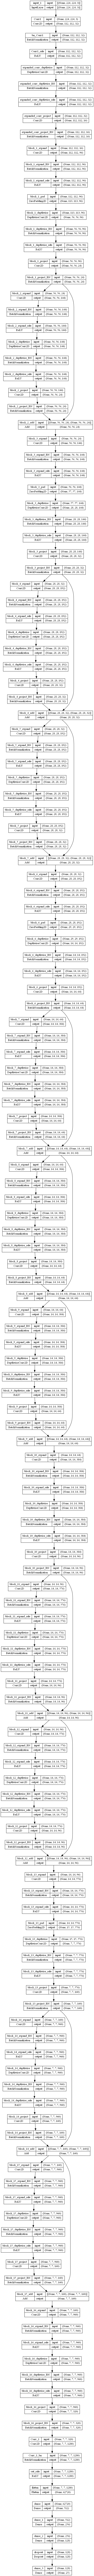

In [19]:
base_model = MobileNetV2(input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels), include_top=False, weights="imagenet")
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(CFG.num_classes, activation="softmax")(x)

# save model
model = Model(inputs=base_model.input, outputs=predictions)
display(model.summary())
display(tf.keras.utils.plot_model(model, to_file="./Results2/model.png", show_shapes=True, show_layer_names=True))


In [20]:
mc = ModelCheckpoint(filepath='./Results2/best_model.h5', monitor='accuracy', mode='max', save_best_only=True, verbose=1)
lg = "./Results2/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
tc = tf.keras.callbacks.TensorBoard(log_dir=lg, histogram_freq=1)
cb = [mc, tc, es]

In [21]:
%%time

with tf.device('/device:GPU:0'):
    # Compile and train the model
    model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    # Train the Model
    history = model.fit(
        train_generator,
        steps_per_epoch=10,
        epochs=CFG.epochs,
        validation_data=validation_generator,
        callbacks=cb 
    )       

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 3.5348 - accuracy: 0.0641
Epoch 1: accuracy improved from -inf to 0.06406, saving model to ./Results2\best_model.h5
10/10 [==============================] - 3747s 414s/step - loss: 3.5348 - accuracy: 0.0641 - val_loss: 2.9227 - val_accuracy: 0.1786
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 3.0730 - accuracy: 0.1172
Epoch 2: accuracy improved from 0.06406 to 0.11719, saving model to ./Results2\best_model.h5
10/10 [==============================] - 3868s 428s/step - loss: 3.0730 - accuracy: 0.1172 - val_loss: 2.6522 - val_accuracy: 0.2543
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 2.6743 - accuracy: 0.2047 
Epoch 3: accuracy improved from 0.11719 to 0.20469, saving model to ./Results2\best_model.h5
10/10 [==============================] - 4101s 454s/step - loss: 2.6743 - accuracy: 0.2047 - val_loss: 2.2789 - val_accuracy: 0.4173
Epoch 4/100
10/10 [====================

In [22]:
# save history to csv

history_df = pd.DataFrame(history.history)
history_df.to_csv("./Results2//history.csv", index=False)



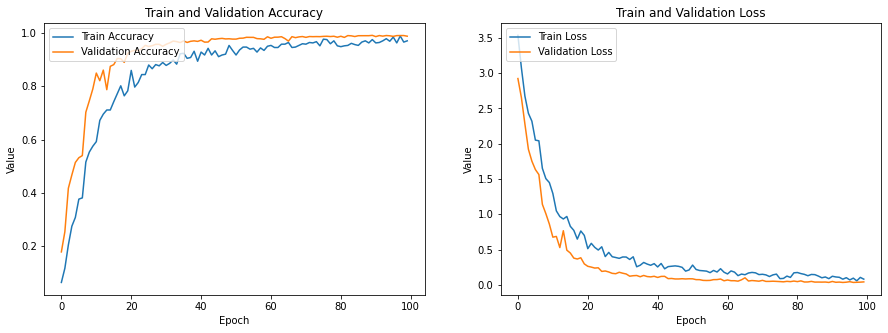

In [23]:
# plot accuracy and loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Train and Validation Loss')
plt.ylabel('Value')
plt.xlabel('Epoch')

plt.legend(loc="upper left")
plt.show()



In [24]:
# load the best model
fine_tune_model = load_model('./Results2/best_model.h5')

In [25]:
loss, acc = fine_tune_model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", acc*100))
print("%s: %.2f" % ("Evaluate Test Loss", loss))


18750/18750 [==============================] - 4742s 253ms/step - loss: 0.0360 - accuracy: 0.9905
Evaluate Test Accuracy: 99.05%
Evaluate Test Loss: 0.04


In [26]:
# confusion matrix

Y_pred = fine_tune_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))


18750/18750 [==============================] - 3854s 205ms/step
Confusion Matrix
[[749   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0]
 [  0 748   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0 750   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0 743   0   0   0   7   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0 747   1   0   1   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0]
 [  0   0   0   0   1 748   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0]
 [  0   7   0   0   0   0 741   0   0   1   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 750   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 750   0   0   0   0   0   0   0   0   0
    0

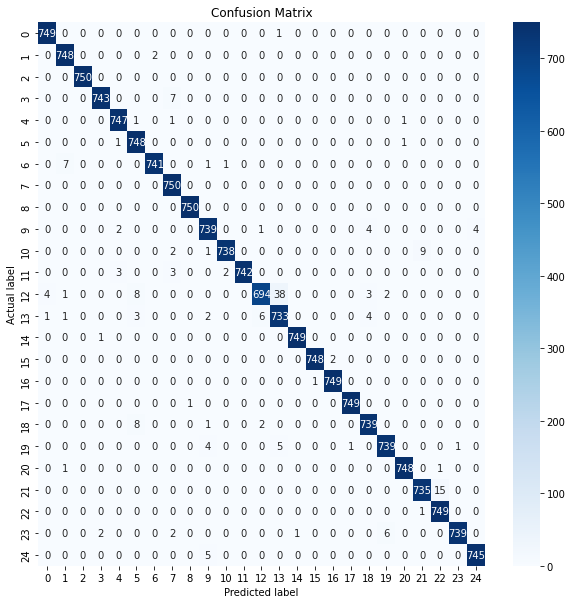

In [27]:
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()



In [28]:
# classification report

print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# save classification report to csv
report = classification_report(test_generator.classes, y_pred, target_names=target_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("./Results2/classification_report.csv", index=False)

Classification Report
              precision    recall  f1-score   support

           A       0.99      1.00      1.00       750
           B       0.99      1.00      0.99       750
       Blank       1.00      1.00      1.00       750
           C       1.00      0.99      0.99       750
           D       0.99      1.00      0.99       750
           E       0.97      1.00      0.99       750
           F       1.00      0.99      0.99       750
           G       0.98      1.00      0.99       750
           H       1.00      1.00      1.00       750
           I       0.98      0.99      0.98       750
           K       1.00      0.98      0.99       750
           L       1.00      0.99      0.99       750
           M       0.99      0.93      0.96       750
           N       0.94      0.98      0.96       750
           O       1.00      1.00      1.00       750
           P       1.00      1.00      1.00       750
           Q       1.00      1.00      1.00       750
     

In [29]:
# accuracy score
print('Accuracy Score', accuracy_score(test_generator.classes, y_pred))

Accuracy Score 0.98992


In [30]:
# precision score
print('Precision Score', precision_score(test_generator.classes, y_pred, average='macro'))

Precision Score 0.9900282020524643


In [31]:
# recall score
print('Recall Score', recall_score(test_generator.classes, y_pred, average='macro'))

Recall Score 0.9899199999999999


In [32]:
# f1 score
print('F1 Score', f1_score(test_generator.classes, y_pred, average='macro'))

F1 Score 0.9899008508324344


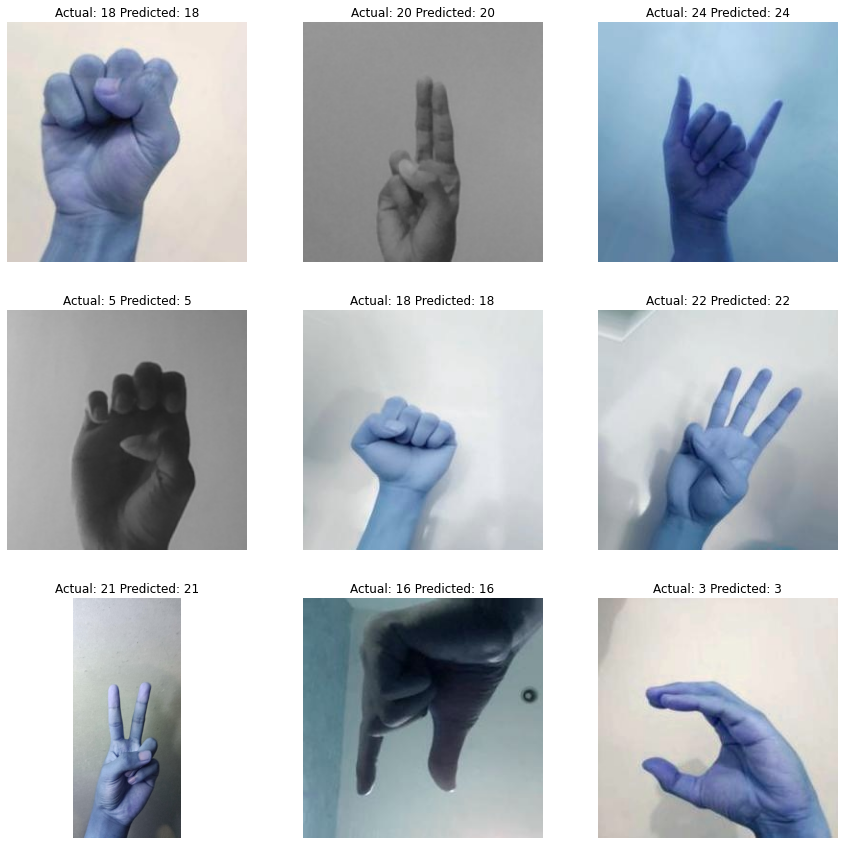

In [33]:
# visualize prediction
plt.figure(figsize=(15, 15))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(test_generator.filepaths[i])
    plt.imshow(img)
    plt.title('Actual: ' + str(test_generator.classes[i]) + ' Predicted: ' + str(y_pred[i]))
    plt.axis('off')
plt.show()



In [34]:
tf.saved_model.save(fine_tune_model, "./Results2/saved_model")
converter = tf.lite.TFLiteConverter.from_saved_model("./Results2/saved_model")
tflite_model = converter.convert()
open("./Results2/model_sibi.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: ./Results2/saved_model\assets


INFO:tensorflow:Assets written to: ./Results2/saved_model\assets


137981224

In [35]:
labels = '\n'.join(sorted(test_generator.class_indices.keys()))

with open('./Results2/labels.txt', 'w') as f:
    f.write(labels)



In [36]:
import numpy as np
import tensorflow as tf

TFLITE_MODEL = "./Results2/model_sibi.tflite"
TFLITE_QUANT_MODEL = "./Results2/model_sibi_quant.tflite"

run_model = tf.function(lambda x : model(x))

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("Size of gzipped baseline Keras model: %.2f bytes" % (len(converted_tflite_model) / 1024))    

print("Size of gzipped quantized TFlite model: %.2f bytes" % (len(tflite_quant_model) / 1024))


Size of gzipped baseline Keras model: 134747.18 bytes
Size of gzipped quantized TFlite model: 33968.99 bytes


In [37]:
interpreter = tf.lite.Interpreter(model_path = TFLITE_QUANT_MODEL)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 25]
Output Type: <class 'numpy.float32'>


In [38]:
def convert_bgr_to_rgb_and_save_show_image(input_path, output_path):
    # convert BGR to RGB
    img = cv2.imread(input_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # save image
    cv2.imwrite(output_path, img)

    # plot result
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')

    plt.show()

In [39]:
def predict_image(image_path):
    # load tflite model and labels
    interpreter = tf.lite.Interpreter(model_path='./Results2/model_sibi_quant.tflite')
    interpreter.allocate_tensors()

    with open('./Results2/labels.txt', 'r') as f:
        labels = f.read().split('\n')

    # load image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    # predict image
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], img)
    interpreter.invoke()
    output = interpreter.tensor(interpreter.get_output_details()[0]['index'])()[0]
    pred = labels[output.argmax()]

    # get output tensor
    output_details = interpreter.get_output_details()[0]
    output_data = np.squeeze(interpreter.get_tensor(output_details['index']))

    # plot result
    plt.figure(figsize=(5, 5))
    plt.imshow(img[0])
    plt.axis('off')
    plt.title('{} : {:.2f}% Confidence'.format(pred, output_data[output.argmax()]*100))
    plt.show()

    return pred, output_data


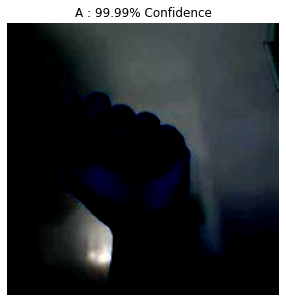

A
[9.9985695e-01 6.8138150e-05 1.1118692e-06 5.1845376e-07 2.9771840e-07
 1.5551612e-05 1.3120416e-06 3.7283096e-06 1.2006076e-06 1.3796119e-07
 2.9135168e-07 1.4330459e-06 2.0093141e-05 2.9899641e-06 2.4303324e-06
 6.5023364e-08 1.6989762e-07 3.2561334e-07 2.1126543e-05 7.6938278e-08
 4.5487230e-08 2.5486740e-08 5.0074453e-07 2.6487930e-07 1.3393209e-06]


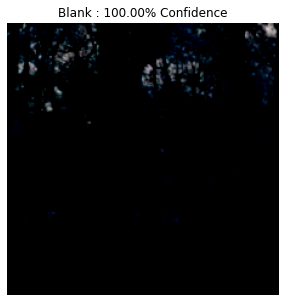

Blank
[1.4145222e-09 5.5615517e-09 9.9999833e-01 1.9498634e-07 8.1028773e-10
 7.2470158e-10 2.2263054e-10 3.3378503e-10 7.1292128e-08 8.1718546e-13
 2.0739428e-09 1.0389506e-09 1.5502280e-08 1.5260138e-08 1.4358838e-07
 5.6597369e-08 2.3137589e-07 5.6742099e-08 3.2624820e-10 9.0599326e-07
 6.4411565e-10 1.6446700e-11 2.0664916e-09 1.2886275e-09 3.1084795e-09]


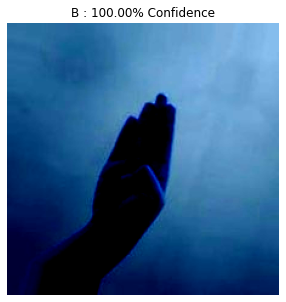

B
[8.4883477e-06 9.9998748e-01 2.8130248e-08 2.9617129e-09 1.7855003e-09
 5.4456294e-08 1.2166114e-06 6.9444916e-08 4.4608356e-10 3.2840013e-08
 1.8532300e-09 1.3568506e-07 1.9648597e-07 1.9785780e-06 5.0480571e-09
 2.6674831e-11 1.0497810e-10 7.8890485e-09 4.3910253e-09 3.5147689e-08
 2.9084725e-07 9.8641498e-11 2.3982132e-08 7.9809796e-12 3.7899930e-11]


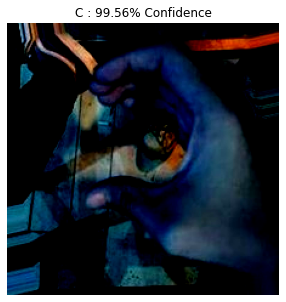

C
[4.0865066e-07 2.4177098e-05 9.7989186e-04 9.9558026e-01 2.7345208e-05
 2.2076067e-05 1.0205317e-04 1.2232426e-05 1.1356293e-04 2.3956793e-06
 2.6567504e-05 3.6993089e-05 8.6022374e-06 2.1866093e-05 2.5585215e-03
 6.8071859e-05 7.0271082e-05 1.4776745e-04 2.5423951e-06 1.0110855e-06
 8.4554961e-07 1.9095942e-06 3.9736427e-05 1.4496190e-04 5.8239643e-06]


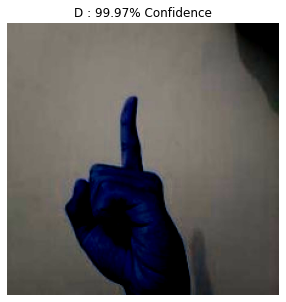

D
[3.3322692e-07 3.6459798e-05 4.1961985e-06 1.6652172e-07 9.9967670e-01
 3.7597857e-07 3.2331394e-05 2.4210510e-06 9.8411374e-06 1.0771155e-05
 5.9781094e-05 8.3749710e-06 9.9094007e-07 9.7926865e-08 7.2708455e-05
 9.9274394e-07 1.0297156e-07 1.1335693e-05 1.3947062e-05 3.0874995e-05
 2.4467565e-05 1.3193189e-06 1.0137809e-06 7.8138775e-08 2.8829450e-07]


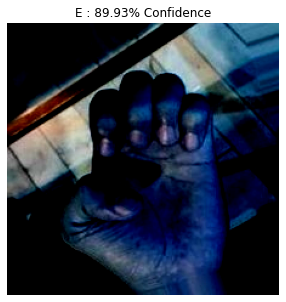

E
[2.23390311e-02 4.30333018e-02 2.06793845e-03 3.93063267e-04
 1.00484285e-05 8.99289548e-01 2.43104470e-04 1.73700100e-05
 8.07460456e-04 6.67168642e-05 4.15866270e-05 5.19558031e-04
 9.73581243e-03 1.97988078e-02 2.16338649e-05 3.84758714e-05
 4.15723953e-05 1.66114754e-04 1.39122189e-04 1.64373720e-04
 1.57428251e-04 5.18597699e-06 6.51814800e-04 1.69522434e-06
 2.49251229e-04]


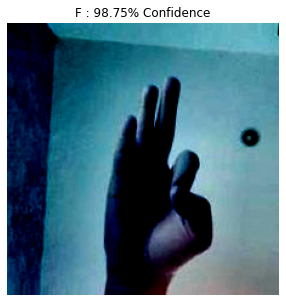

F
[1.82105050e-05 2.14689085e-03 2.58428317e-05 6.67300919e-05
 1.46168543e-06 1.83045449e-05 9.87534046e-01 1.28695247e-05
 3.32220043e-06 5.24509524e-04 5.23578201e-05 4.62988683e-05
 1.19178527e-04 3.54724434e-05 2.19210506e-05 8.57973589e-07
 1.04234554e-04 8.86474620e-04 1.41585362e-04 2.85134627e-03
 1.03906495e-03 2.53854552e-04 4.08987422e-03 1.98431007e-06
 3.19410651e-06]


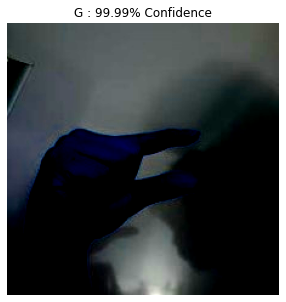

G
[7.82582088e-09 3.44658645e-07 5.87683218e-08 1.47064853e-07
 1.76432273e-08 1.08864064e-07 1.66838934e-08 9.99871373e-01
 1.18788616e-04 3.76382570e-09 1.45331654e-07 3.99919873e-06
 2.38899158e-08 1.97959587e-08 1.61724302e-07 1.99480792e-06
 1.75319087e-06 1.77560636e-07 2.96658698e-09 3.50939331e-07
 7.15683246e-09 6.00613614e-10 2.14744613e-08 7.32587040e-08
 2.99721137e-07]


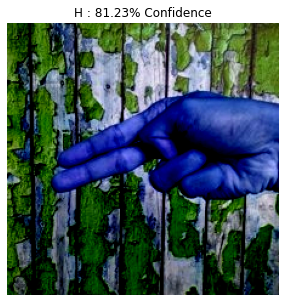

H
[1.09524082e-03 1.83822558e-04 1.01288583e-03 1.81806798e-04
 5.42479334e-03 1.91063655e-03 2.37831424e-04 2.42597447e-03
 8.12279701e-01 2.16886532e-04 2.42585840e-04 1.58730254e-03
 1.01606012e-03 1.90764797e-04 1.38481567e-03 1.59812272e-01
 1.16408606e-04 1.92660175e-03 5.75081387e-04 2.89157382e-04
 8.96633894e-04 6.19719649e-05 6.26796900e-05 1.41573037e-04
 6.72659278e-03]


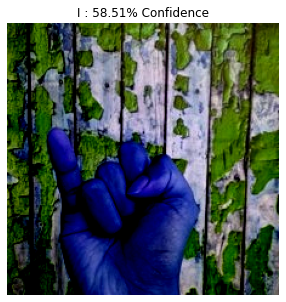

I
[1.8571433e-02 3.1700216e-03 4.3201377e-03 1.5352105e-03 2.0042078e-03
 4.1692164e-03 7.6789623e-03 1.1933943e-03 2.9581378e-03 5.8513427e-01
 9.9811051e-04 8.9003993e-03 3.1817365e-02 4.1905753e-02 1.7308326e-03
 1.9738113e-03 6.7300636e-05 4.3319841e-03 7.6422179e-03 1.3795991e-03
 1.3843385e-03 3.9282086e-04 8.1426895e-04 1.2956259e-03 2.6463053e-01]


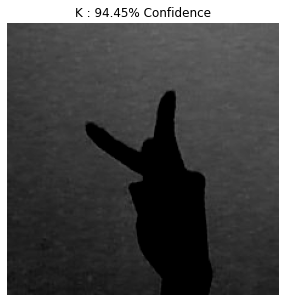

K
[1.1741395e-04 2.7573510e-04 5.0595208e-06 5.1213402e-07 1.7126998e-03
 3.5821547e-06 6.5400923e-06 8.6281980e-06 5.3003710e-06 8.9774694e-06
 9.4452626e-01 1.3333558e-05 7.5263124e-05 1.2375083e-08 1.6889691e-04
 4.3502292e-05 2.0566256e-05 2.5688636e-03 1.1288822e-06 1.1992599e-05
 1.2138410e-02 3.6767453e-02 1.4739177e-03 5.3045949e-07 4.5374385e-05]


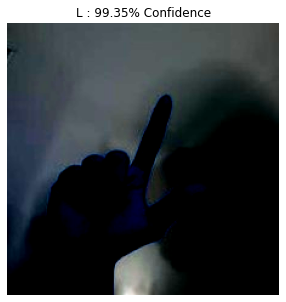

L
[8.2657043e-06 1.3897735e-04 1.4897778e-07 6.2769328e-07 4.3226605e-06
 3.0338992e-07 2.0146395e-05 7.3905799e-06 4.1578332e-07 4.6695222e-06
 9.3248100e-06 9.9351078e-01 7.5186717e-06 4.9644171e-08 5.8477593e-07
 4.6736056e-07 5.8760077e-07 1.7667784e-06 2.9773187e-07 1.0538106e-05
 8.7913293e-05 5.6847283e-03 4.9307832e-04 1.2059941e-07 6.9884372e-06]


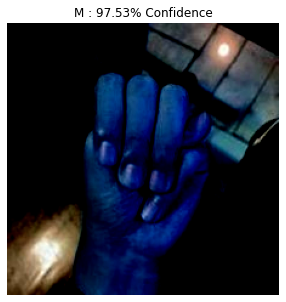

M
[1.8639563e-04 5.9658745e-03 1.1071181e-03 2.2068032e-05 2.6420880e-06
 4.4849476e-05 6.5540546e-05 1.9692745e-04 1.0843520e-06 1.2006169e-05
 5.9631175e-06 5.3691278e-06 9.7532856e-01 9.3815122e-03 1.4848096e-05
 7.9609563e-06 4.4438661e-05 4.2473679e-04 9.4891066e-06 7.1158870e-03
 2.4090118e-06 6.0015219e-07 2.7823909e-05 4.1257175e-07 2.5483272e-05]


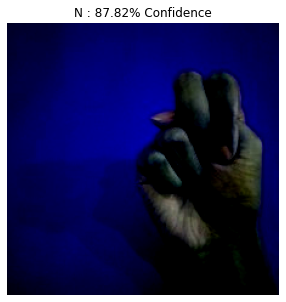

N
[1.7713291e-03 1.0350044e-03 1.8951644e-03 3.8046390e-04 3.6587983e-06
 2.3328421e-04 1.3579904e-04 6.7771784e-05 2.2649961e-04 2.4073410e-03
 5.1183638e-06 1.0037075e-04 1.0883372e-01 8.7815028e-01 4.2426069e-05
 1.7847511e-05 4.4382279e-05 2.0023092e-04 3.5199829e-04 4.1048921e-04
 2.9651887e-05 1.1110882e-05 1.6499663e-04 7.9498413e-06 3.4730821e-03]


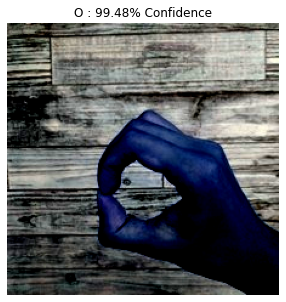

O
[2.8995699e-05 2.2227068e-05 1.0250108e-03 6.2687301e-05 8.7734166e-04
 1.6433080e-05 3.6862046e-05 2.5084162e-05 2.7188912e-04 1.5109829e-05
 1.8766255e-05 5.5634177e-07 3.3902947e-04 6.4422289e-05 9.9484563e-01
 8.8906228e-07 1.0601502e-06 1.2519580e-06 1.7540794e-04 2.8012562e-05
 3.0384999e-07 1.2567226e-06 6.4802998e-06 2.1161838e-03 1.9135492e-05]


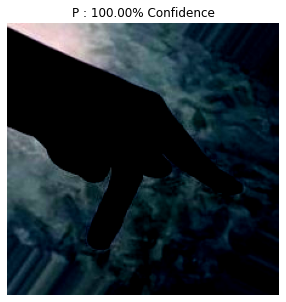

P
[2.7437463e-10 2.0927666e-09 1.8697395e-07 1.7243918e-08 3.7258434e-07
 6.5493615e-09 3.1949543e-10 2.9747804e-08 2.4487304e-07 3.7385213e-11
 3.0471543e-07 3.2829945e-07 4.6849772e-07 1.5402904e-08 2.3395101e-08
 9.9996054e-01 3.6126199e-05 6.2780111e-07 1.2497186e-07 8.8983780e-09
 3.7169759e-08 4.5532505e-07 2.9222607e-08 5.4459059e-09 1.1190083e-07]


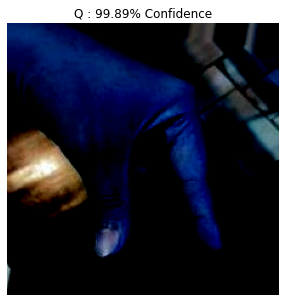

Q
[1.1227182e-08 2.4808781e-08 1.5511843e-06 3.9155562e-08 2.2738080e-07
 4.2413442e-09 5.6235547e-07 2.3776061e-06 2.9636792e-07 1.2396958e-08
 8.2500177e-05 1.1901813e-05 3.7602763e-07 8.1592938e-10 8.3288717e-07
 9.2151214e-04 9.9893600e-01 1.7063061e-06 1.6092913e-07 1.4042939e-07
 8.2330274e-08 1.1805522e-05 2.4750143e-05 3.8253901e-07 2.6193857e-06]


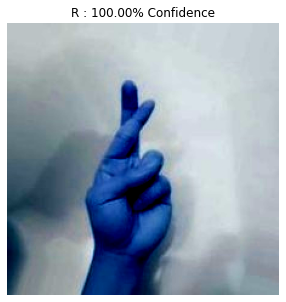

R
[1.3103015e-10 4.3381951e-09 1.7641522e-10 9.7090014e-10 3.0422515e-10
 3.3440148e-09 5.0545439e-11 1.7670262e-12 4.3809036e-12 1.9540096e-09
 2.6134850e-07 6.1856881e-10 1.7014788e-09 6.7983861e-12 4.4587823e-11
 2.9416797e-10 6.0136958e-11 9.9999869e-01 2.6440485e-08 2.8159015e-08
 1.0637408e-06 6.7585626e-09 2.3512474e-09 1.6989876e-10 2.1981423e-09]


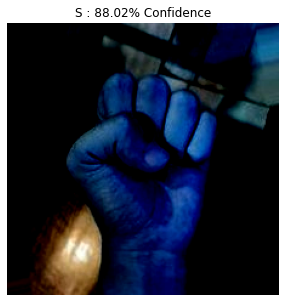

S
[6.4374809e-04 9.5080782e-04 6.6779801e-05 2.6903610e-04 2.4873314e-05
 2.4655992e-03 4.3474408e-03 1.6499410e-03 1.8198893e-04 4.2508990e-02
 1.5751768e-03 6.3508960e-05 3.0428955e-02 5.2476618e-03 7.5122039e-04
 4.1324893e-05 4.9633038e-04 4.2990292e-03 8.8023591e-01 4.7384286e-03
 2.7400299e-04 1.4427245e-04 2.4481138e-04 1.6297151e-04 1.8187208e-02]


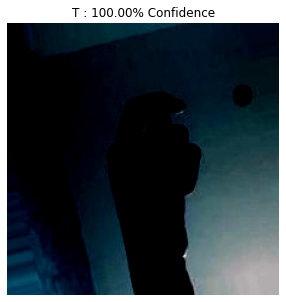

T
[2.6238955e-09 1.6105281e-07 8.2863826e-06 8.1404210e-08 3.0441136e-10
 7.3966100e-09 2.1494386e-09 4.7520952e-09 4.9917685e-11 4.2798376e-11
 1.0444872e-07 3.6906980e-10 9.4536182e-07 1.1534802e-07 1.0194027e-07
 2.9010203e-10 4.7119066e-08 2.0525056e-07 5.1432113e-07 9.9998879e-01
 7.7574969e-09 3.6062261e-11 1.5225257e-07 4.7934429e-07 7.2556605e-10]


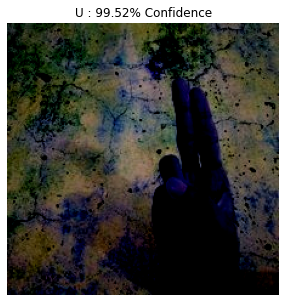

U
[3.6006990e-05 3.3593448e-04 1.1390330e-05 7.1262917e-07 3.5004134e-05
 4.8636848e-06 1.5661682e-04 6.6810861e-07 2.1836249e-06 2.1615664e-05
 8.1059977e-04 2.4851399e-05 2.6467424e-05 8.8269184e-07 2.3540797e-05
 2.1890807e-07 7.2614654e-08 3.9397721e-04 1.8453845e-06 2.2481945e-05
 9.9517447e-01 1.7518668e-03 1.1600049e-03 2.7711391e-07 3.3872841e-06]


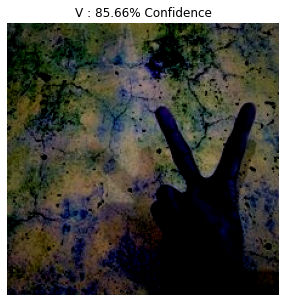

V
[4.41909106e-05 8.42918416e-06 5.80000062e-07 8.37223354e-07
 1.20732271e-04 4.44061101e-07 1.28955060e-06 3.30643866e-06
 2.93205194e-05 2.26388170e-06 1.31673727e-03 7.42193006e-05
 1.08451068e-05 1.27480462e-07 1.02683975e-04 1.83263899e-06
 5.18809211e-05 8.07090203e-07 6.40235839e-07 1.99482224e-06
 7.64473734e-05 8.56563687e-01 1.41574964e-01 7.34842899e-07
 1.11070140e-05]


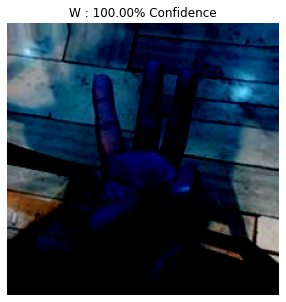

W
[5.70272232e-11 3.29915435e-11 9.35548774e-12 1.14746035e-09
 5.45389688e-12 8.09110140e-11 2.65532873e-10 1.80326836e-12
 2.44521459e-10 1.74982417e-10 6.61892069e-11 4.86971661e-12
 6.90566267e-12 3.77316955e-10 5.63263759e-12 4.23285674e-14
 2.75913570e-10 1.35145828e-13 3.88889441e-12 1.25413541e-10
 7.31497585e-10 3.50866856e-07 9.99999642e-01 1.05184457e-13
 2.83684631e-09]


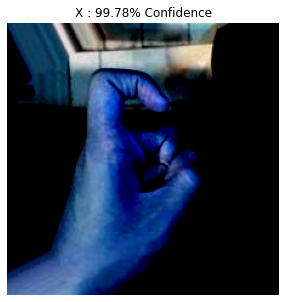

X
[5.1116280e-07 5.7625042e-05 3.7461243e-06 2.6566861e-04 1.5924140e-06
 6.0893399e-06 2.3871526e-04 3.6894216e-06 3.7150458e-05 6.3880492e-05
 1.0736251e-05 6.5126910e-06 2.2847675e-05 1.6371872e-05 1.0395120e-03
 2.0837044e-06 1.7606701e-05 4.5694978e-05 5.5588214e-05 2.5216892e-04
 2.8967056e-06 8.7406755e-07 3.0973022e-06 9.9783981e-01 5.4081256e-06]


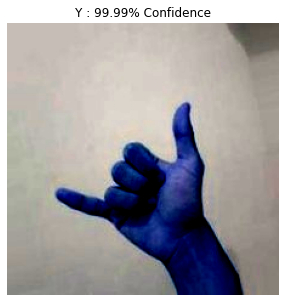

Y
[9.09851792e-07 2.04856310e-08 1.05432726e-07 2.54447696e-06
 1.13516698e-08 6.82715324e-07 1.05007712e-06 4.94384767e-06
 7.61053661e-06 3.41795967e-05 3.58364844e-07 5.37691776e-05
 9.16458430e-06 2.14931310e-06 1.43215821e-08 1.39299698e-06
 1.78127491e-09 1.67971245e-06 6.19241973e-07 1.21255383e-07
 1.37205106e-07 3.22299520e-08 8.39607537e-07 1.10324970e-06
 9.99876499e-01]


In [40]:
test_path = './testd/'
for i in os.listdir(test_path):
    pred, output_data = predict_image(test_path + i)
    print(pred)
    print(output_data)


        